# Importando bibliotecas

In [1]:
import logging
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
from stable_baselines3 import DQN
from stable_baselines3.dqn.policies import MlpPolicy
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import time
from torch import nn  # Import the neural network module from PyTorch
import gym
from gym import spaces
from sklearn.model_selection import train_test_split
from stable_baselines3 import DQN
from stable_baselines3.dqn.policies import MlpPolicy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecEnv
from stable_baselines3.common.evaluation import evaluate_policy
import sys
import os
sys.path.append(os.path.join('..'))
from classes._exploration import exploration
from classes._Env3WGym import Env3WGym



2024-03-11 14:17:00.666084: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-11 14:17:00.697382: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-11 14:17:00.697415: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-11 14:17:00.698446: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-11 14:17:00.704950: I tensorflow/core/platform/cpu_feature_guar

In [2]:
def class_and_file_generator(data_path, real=False, simulated=False, drawn=False):
    for class_path in data_path.iterdir():
        if class_path.is_dir():
            try:
                class_code = int(class_path.stem)
            except ValueError:
                # Se não for possível converter para int, pule este diretório
                continue

            for instance_path in class_path.iterdir():
                if (instance_path.suffix == '.csv'):
                    if (simulated and instance_path.stem.startswith('SIMULATED')) or \
                       (drawn and instance_path.stem.startswith('DRAWN')) or \
                       (real and (not instance_path.stem.startswith('SIMULATED')) and \
                       (not instance_path.stem.startswith('DRAWN'))):
                        yield class_code, instance_path

In [3]:
def load_instance_with_numpy(data_path, events_names, columns):
    data_path = Path(data_path)
  

    well_names = ['WELL-00001','WELL-00002', 'WELL-00004', 'WELL-00005', 'WELL-00007']

    real_instances = list(class_and_file_generator(data_path, real=True, simulated=False, drawn=False))

    arrays_list = []  # List to store processed NumPy arrays

    for instance in real_instances:
        class_code, instance_path = instance    
        well, _ = instance_path.stem.split('_')  
             
        if class_code in events_names and well in well_names:

            # Read the entire CSV file into a NumPy array
            with open(instance_path, 'r') as file:
                header = file.readline().strip().split(',')
                indices = [header.index(col) for col in columns]
                
                                                
                if 'timestamp' in columns:
                    arr = np.genfromtxt(file, delimiter=',', usecols=indices[1:], dtype=np.float32)
                    arr[:, :-1] = arr[:, :-1].astype(np.float32)  # Convert selected columns to float32
                    arr[:, -1] = arr[:, -1].astype(np.int16)  # Convert 'class' column to int16
                    timestamp_idx = header.index('timestamp')
                    file.seek(0)
                    file.readline()  # Pula o cabeçalho
                    timestamps = np.genfromtxt(file, delimiter=',', skip_header=0, usecols=timestamp_idx, dtype=str)
                    if isinstance(timestamps, str):                
                        timestamps = np.array([timestamps])

                    fmt = "%Y-%m-%d %H:%M:%S.%f"
                    rounded_timestamps = [datetime.strptime(ts, fmt).strftime("%Y-%m-%d %H:%M:%S") for ts in timestamps]
                    
                    # Combinação dos timestamps arredondados e dados numéricos
                    final_data = np.hstack([np.array(rounded_timestamps).reshape(-1, 1), arr])                    
                    arrays_list.append(final_data)
                else:
                    arr = np.genfromtxt(file, delimiter=',', usecols=indices, dtype=np.float32)
                    arr[:, :-1] = arr[:, :-1].astype(np.float32)  # Convert selected columns to float32
                    arr[:, -1] = arr[:, -1].astype(np.int16)  # Convert 'class' column to int16
                    arr = arr[~np.isnan(arr).any(axis=1)]
                    arrays_list.append(arr)               

                

    # Concatenate all processed NumPy arrays
    final_array = np.concatenate(arrays_list)

    return final_array

In [4]:
def env3W_dqn(env):

    # Instanciar o modelo DQN com a política MLP
    model = DQN(
        policy=MlpPolicy,
        env=env,
        learning_rate=1e-4,
        buffer_size=10000,
        learning_starts=10000,
        batch_size=32,
        tau=1.0,
        gamma=0.99,
        train_freq=4,
        gradient_steps=1,
        target_update_interval=1000,
        exploration_fraction=0.1,
        exploration_initial_eps=1.0,
        exploration_final_eps=0.01,
        max_grad_norm=10,
        tensorboard_log=None,
        verbose=1,
        device='auto'
    )

    # Treinar o modelo
    model.learn(total_timesteps=int(1.2e5))

    # Salvar o modelo
    model.save('dqn_env3W')

    env.close()

In [5]:
def env3W_dqn_eval(model, env, n_eval_episodes=1):
    # Inicializa listas para armazenar os dados de cada episódio
    correct_predictions_list = []
    total_predictions_list = []

    for episode in range(n_eval_episodes):
        obs = env.reset()
        done = [False]

        # Reseta contadores para o episódio atual
        correct_predictions = 0
        total_predictions = 0

        while not all(done):
            action, _states = model.predict(obs, deterministic=True)
            obs, rewards, done, info = env.step(action)

            for reward in rewards:
                if reward > 0:
                    correct_predictions += 1
                total_predictions += 1

        # Atualiza a mensagem de log para incluir a recompensa e a porcentagem de acerto
        if total_predictions > 0:  # Evita divisão por zero
            percentage_correct = correct_predictions / total_predictions
            logging.info(f"[{episode}] Recompensa: {correct_predictions}, Porcentagem de acerto: {percentage_correct:.2f}.")
            print(f"[{episode}] Recompensa: {correct_predictions}, Porcentagem de acerto: {percentage_correct:.2f}.")
        else:
            logging.info(f"[{episode}] Sem predições.")
            print(f"[{episode}] Sem predições.")

        # Armazena os dados do episódio atual nas listas
        correct_predictions_list.append(correct_predictions)
        total_predictions_list.append(total_predictions)

    # Calcula a precisão geral
    accuracy = sum(correct_predictions_list) / sum(total_predictions_list) if sum(total_predictions_list) > 0 else 0

    
    return accuracy

Número de amostras da classe 0: 6372575
Número de amostras da classe 4: 1711754


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
DQN Training Time: 20.15431571006775


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1100, in emit
    msg = self.format(record)
  File "/usr/lib/python3.10/logging/__init__.py", line 943, in format
    return fmt.format(record)
  File "/usr/lib/python3.10/logging/__init__.py", line 678, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.10/logging/__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/root/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/root/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.st

[0] Recompensa: 7276530, Porcentagem de acerto: 0.90.


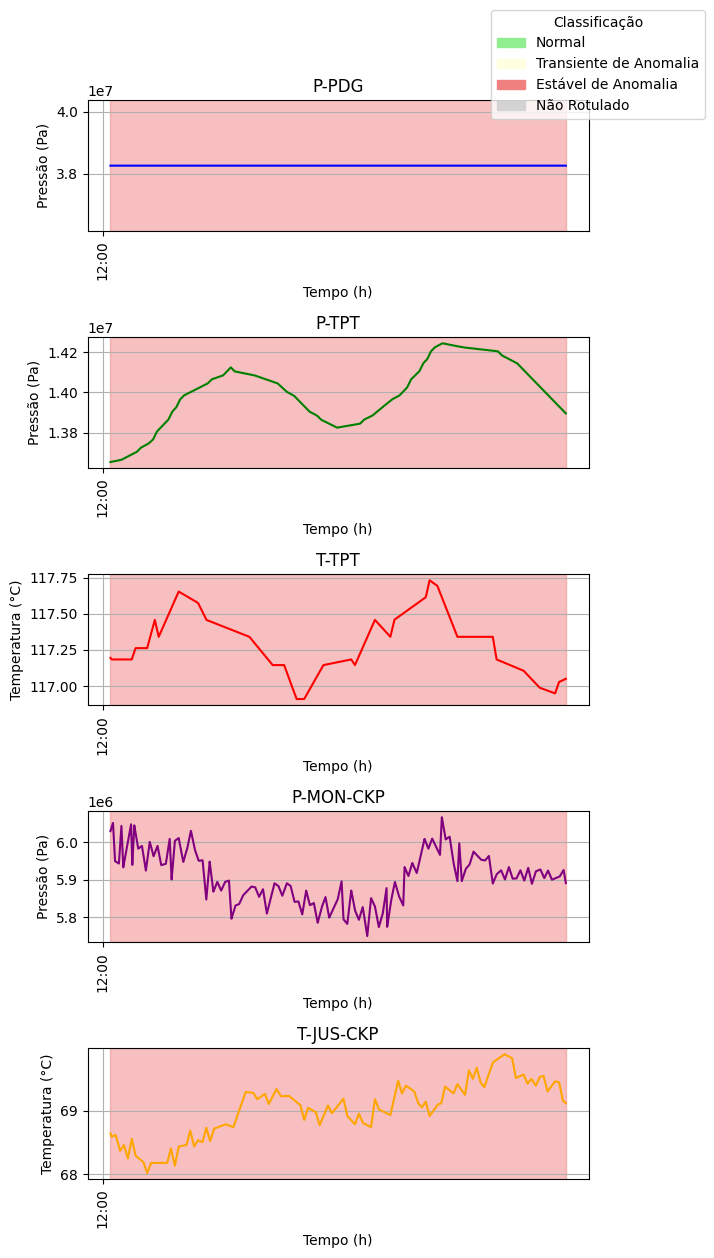

In [14]:
if __name__ == '__main__':

    
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    log_filename = f'/home/Reinforcement-Learning/logs/{current_time}_RL-log.txt'
    # Configuração do Logging
    logging.basicConfig(filename=log_filename, filemode='w', level=logging.INFO, format='[%(levelname)s]\t%(asctime)s - %(message)s', datefmt='%d/%m/%Y %I:%M:%S %p', force=True)

    path_dataset = '/home/dataset'
    events_names = {
        0: 'Normal',
        # 1: 'Abrupt Increase of BSW',
        # 2: 'Spurious Closure of DHSV',
        # 3: 'Severe Slugging',
        4: 'Flow Instability',
        # 5: 'Rapid Productivity Loss',
        # 6: 'Quick Restriction in PCK',
        # 7: 'Scaling in PCK',
        # 8: 'Hydrate in Production Line'
    }

    columns = [       
        'P-PDG',
        'P-TPT',
        'T-TPT',
        'P-MON-CKP',
        'T-JUS-CKP',
        #'P-JUS-CKGL',
        #'T-JUS-CKGL',
        #'QGL',
        'class'
    ]
    
    logging.info(f'Iniciando carregamento do dataset')
    dataset = load_instance_with_numpy(data_path = path_dataset, events_names = events_names, columns = columns)    
    logging.info(f'Fim carregamento do dataset')
    
    logging.info(f'Iniciando divisão do dataset em treino e teste')
    
    # Filtrar índices que correspondem aos eventos de interesse
    condition = np.isin(dataset[:, -1], list(events_names.keys()))
    indices = np.where(condition)[0]

    # Definindo a porcentagem para divisão entre treino e teste
    train_percentage = 0.8  # 80% para treino

    # Inicializando listas para guardar índices de treino e teste
    train_indices = []
    test_indices = []

    # Processamento genérico para cada classe
    for event in events_names.keys():
        # Selecionando índices para a classe atual
        class_indices = indices[dataset[indices, -1] == event]
        
        # Logando o número de amostras por classe
        print(f'Número de amostras da classe {event}: {len(class_indices)}')
        logging.info(f'Número de amostras da classe {event}: {len(class_indices)}')
        
        # Dividindo os índices da classe atual em treino e teste
        class_train_indices, class_test_indices = train_test_split(class_indices, train_size=train_percentage, random_state=42)
        
        # Logando o número de amostras de treino e teste
        logging.info(f'Número de amostras de treino da classe {event}: {len(class_train_indices)}')
        logging.info(f'Número de amostras de teste da classe {event}: {len(class_test_indices)}')
        
        # Adicionando aos índices gerais de treino e teste
        train_indices.extend(class_train_indices)
        test_indices.extend(class_test_indices)

    # Convertendo listas para arrays numpy para futura manipulação
    train_indices = np.array(train_indices)
    test_indices = np.array(test_indices)

    # Embaralhando os índices (opcional, dependendo da necessidade)
    np.random.shuffle(train_indices)
    np.random.shuffle(test_indices)

    # Criando conjuntos de dados de treino e teste
    dataset_train = dataset[train_indices]
    dataset_test = dataset[test_indices]

    # Dividindo em features (X) e target (y)
    X_train, y_train = dataset_train[:, :-1], dataset_train[:, -1]
    X_test, y_test = dataset_test[:, :-1], dataset_test[:, -1]

    # Escalonando as features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    logging.info(f'Fim divisão do dataset em treino e teste')

    # Se necessário, você pode combinar as features escalonadas e o target para formar os datasets finais
    dataset_train_scaled = np.column_stack((X_train_scaled, y_train))
    dataset_test_scaled = np.column_stack((X_test_scaled, y_test))
    
    logging.info(f'Iniciando treinamento do modelo DQN')
    start_time = time.time()
    # Crie o ambiente (modifique conforme necessário para seu caso de uso)
    env = make_vec_env(lambda: Env3WGym(dataset_train_scaled), n_envs=5)
    env3W_dqn(env)  # Chamar a função para treinar o modelo
    print("DQN Training Time:", time.time() - start_time)
    logging.info("DQN Training Time:", time.time() - start_time)
    logging.info(f'Fim treinamento do modelo DQN')

    logging.info(f'Iniciando avaliação do modelo de teste DQN')
    dqn_model = DQN.load('dqn_env3W')
    env = make_vec_env(lambda: Env3WGym(dataset_test_scaled), n_envs=5)
    # Executar a função de avaliação
    accuracy = env3W_dqn_eval(dqn_model, env)
    logging.info(f'Acurácia: {accuracy}')
    logging.info(f'Fim avaliação do modelo de teste DQN')

    logging.info(f'Iniciando o teste do modelo de teste DQN')
    columns = [
        'timestamp',
        'P-PDG',
        'P-TPT',
        'T-TPT',
        'P-MON-CKP',
        'T-JUS-CKP',
        #'P-JUS-CKGL',
        #'T-JUS-CKGL',
        #'QGL',
        'class'        
    ]
    dataset_test = load_instance_with_numpy(data_path = '/home/dataset_test', events_names = events_names, columns = columns)
    array_action_pred = []
    for i in range(0, len(dataset_test)):
        obs = dataset_test[i, 1:-1].astype(np.float32)
        action, _states = dqn_model.predict(obs, deterministic=True)  
        array_action_pred.append(action)

    
    expanded_array = np.column_stack((dataset_test, array_action_pred))

    logging.info(f'Fim do teste do modelo de teste DQN')
   
    
    df = pd.DataFrame(expanded_array, columns = ['timestamp', 'P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'class', 'action'])
    df.set_index('timestamp', inplace=True)
    df[['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP']] = df[['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP']].astype('float32')
    df['class'] = df['class'].astype(float).astype('int16')


    explora = exploration(df)
    explora.plot_sensor(sensor_columns = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP'], _title = 'Plot DQN')